In [3]:
from qiskit.ml.datasets import *
from qiskit import QuantumCircuit
from qiskit.aqua.components.optimizers import COBYLA, ADAM, SPSA, SLSQP, POWELL, L_BFGS_B, TNC, AQGD
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit.quantum_info import Statevector

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [4]:
# constants
n = 4
RANDOM_STATE = 42
LR = 1e-3
class_labels = ['yes', 'no']

In [7]:
def normalizeData(DATA_PATH = "../../Data/Processed/iris_csv.csv"):
    """
    Normalizes the data
    """
    # Reads the data
    data = pd.read_csv(DATA_PATH)
    data = shuffle(data, random_state=RANDOM_STATE)
    X, Y = data[['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']].values, data['target'].values
    # normalize the data
    scaler = MinMaxScaler(feature_range=(-2 * np.pi, 2 * np.pi))
    X = scaler.fit_transform(X)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=RANDOM_STATE)
    return X_train, X_test, Y_train, Y_test

In [8]:
X_train, X_test, Y_train, Y_test = normalizeData()

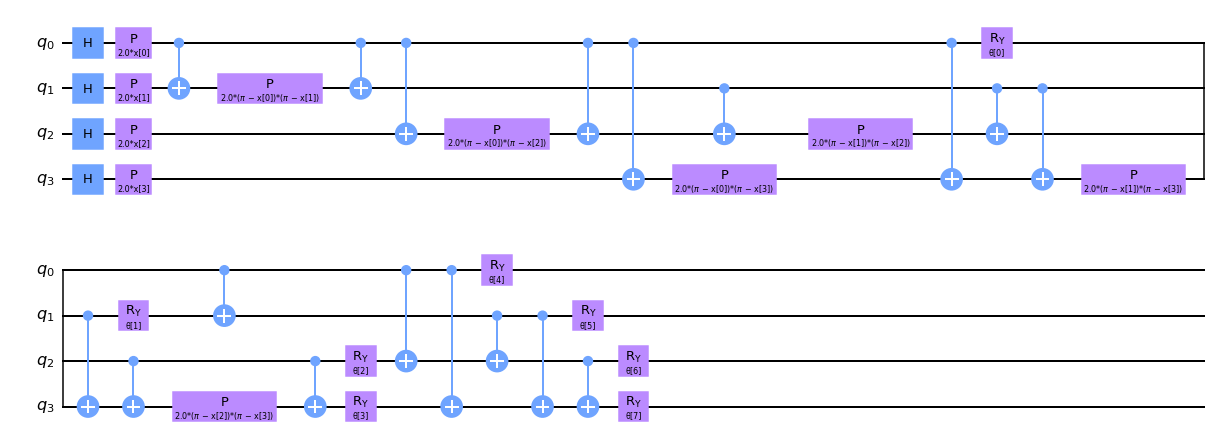

In [9]:
sv = Statevector.from_label('0' * n)
feature_map = ZZFeatureMap(n, reps=1)
var_form = RealAmplitudes(n, reps=1)
circuit = feature_map.combine(var_form)
circuit.draw(output='mpl')

In [10]:
def get_data_dict(params, x):
    parameters = {}
    for i, p in enumerate(feature_map.ordered_parameters):
        parameters[p] = x[i]
    for i, p in enumerate(var_form.ordered_parameters):
        parameters[p] = params[i]
    return parameters

In [11]:
def assign_label(bit_string, class_labels):
    hamming_weight = sum([int(k) for k in list(bit_string)])
    is_odd_parity = hamming_weight & 1
    if is_odd_parity:
        return class_labels[1]
    else:
        return class_labels[0]

In [12]:
def return_probabilities(counts, class_labels):
    shots = sum(counts.values())
    result = {class_labels[0]: 0,
    class_labels[1]: 0}
    for key, item in counts.items():
        label = assign_label(key, class_labels)
        result[label] += counts[key]/shots
    return result

In [13]:
def classify(x_list, params, class_labels):
    qc_list = []
    for x in x_list:
        circ_ = circuit.assign_parameters(get_data_dict(params, x))
        qc = sv.evolve(circ_)
        qc_list += [qc]
        probs = []
    for qc in qc_list:
        counts = qc.to_counts()
        prob = return_probabilities(counts, class_labels)
        probs += [prob]
    return probs

In [14]:
def mse_cost(probs, expected_label):
    p = probs.get(expected_label)
    actual, pred = np.array(1), np.array(p)
    return np.square(np.subtract(actual,pred)).mean()

In [15]:
cost_list = []
def cost_function(X, Y, class_labels, params, shots=100, print_value=False):
    # map training input to list of labels and list of samples
    cost = 0
    training_labels = []
    training_samples = []
    for sample in X:
        training_samples += [sample]
    for label in Y:
        if label == 0:
            training_labels += [class_labels[0]]
        elif label == 1:
            training_labels += [class_labels[1]]
    probs = classify(training_samples, params, class_labels)
    # evaluate costs for all classified samples
    for i, prob in enumerate(probs):
        cost += mse_cost(prob, training_labels[i])
    cost /= len(training_samples)
    # print resulting objective function
    if print_value:
        print('%.4f' % cost)
    # return objective value
    cost_list.append(cost)
    return cost

In [16]:
cost_list = []
optimizer = SPSA(maxiter=100)

# define objective function for training
objective_function = lambda params: cost_function(X_train, Y_train, class_labels, params, print_value=True)
# randomly initialize the parameters
np.random.seed(RANDOM_STATE)
init_params = 2*np.pi*np.random.rand(n*(1)*2)
# train classifier
opt_params, value, _ = optimizer.optimize(len(init_params), objective_function, initial_point=init_params)
# print results
print()
print('opt_params:', opt_params)
print('opt_value: ', value)

0.2491
0.2440
0.2485
0.2441
0.2420
0.2536
0.2423
0.2510
0.2485
0.2469
0.2506
0.2429
0.2400
0.2539
0.2472
0.2450
0.2478
0.2462
0.2477
0.2472
0.2538
0.2391
0.2401
0.2542
0.2452
0.2492
0.2536
0.2420
0.2545
0.2386
0.2425
0.2509
0.2457
0.2456
0.2515
0.2407
0.2468
0.2447
0.2439
0.2491
0.2425
0.2503
0.2383
0.2349
0.2370
0.2391
0.2405
0.2365
0.2411
0.2374
0.2369
0.2355
0.2371
0.2372
0.2342
0.2378
0.2315
0.2366
0.2302
0.2300
0.2316
0.2307
0.2319
0.2305
0.2276
0.2335
0.2251
0.2294
0.2257
0.2263
0.2269
0.2250
0.2249
0.2256
0.2262
0.2246
0.2248
0.2261
0.2224
0.2279
0.2206
0.2243
0.2220
0.2211
0.2206
0.2221
0.2229
0.2199
0.2212
0.2200
0.2200
0.2207
0.2204
0.2199
0.2205
0.2199
0.2200
0.2209
0.2200
0.2210
0.2201
0.2199
0.2208
0.2195
0.2203
0.2194
0.2206
0.2195
0.2187
0.2200
0.2200
0.2193
0.2196
0.2193
0.2197
0.2193
0.2194
0.2199
0.2198
0.2199
0.2187
0.2196
0.2192
0.2186
0.2194
0.2192
0.2197
0.2197
0.2186
0.2194
0.2197
0.2193
0.2192
0.2200
0.2199
0.2188
0.2196
0.2196
0.2193
0.2198
0.2200
0.2195
0.2191

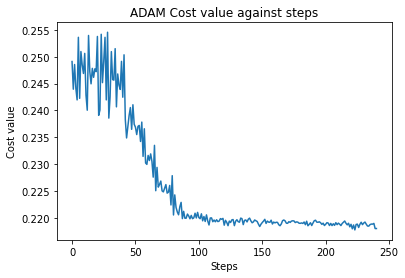

In [17]:
fig = plt.figure()
plt.plot(range(0,len(cost_list),1), cost_list)
plt.xlabel('Steps')
plt.ylabel('Cost value')
plt.title("ADAM Cost value against steps")
plt.show()


In [18]:
def test_model(X, Y, class_labels, params):
    accuracy = 0
    training_labels = []
    training_samples = []
    for sample in X:
        training_samples += [sample]
    probs = classify(training_samples, params, class_labels)
    for i, prob in enumerate(probs):
        if (prob.get('yes') >= prob.get('no')) and (Y_test[i] == 0):
            accuracy += 1
        elif (prob.get('no') >= prob.get('yes')) and (Y_test[i] == 1):
            accuracy += 1
    accuracy /= len(Y_test)
    print("Test accuracy: {}\n".format(accuracy))

In [19]:
test_model(X_test, Y_test, class_labels, opt_params)

Test accuracy: 0.6

